In [4]:
from risk_experiment.utils.data import Subject, get_all_subjects
from tqdm import tqdm
import pandas as pd
from scipy.stats import zscore
import nideconv

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [68]:
roi = 'vta'

In [69]:
def get_data(model_label, roi, bids_folder, session='7t2'):
    subjects = get_all_subjects(bids_folder)

    ts = pd.concat([sub.get_roi_timeseries(session, roi) for sub in subjects]).droplevel('session').droplevel('frame')
    events = pd.concat([sub.get_fmri_events(session) for sub in subjects], keys=[sub.subject for sub in subjects], names=['subject']).set_index('trial_nr', append=True).reset_index('session', drop=True)
    behavior = pd.concat([sub.get_behavior(sessions=session) for sub in subjects]).reset_index('session', drop=True)

    confounds = pd.concat([pd.concat(sub.get_confounds(session, pca=False), keys=range(1, 9), names=['run']) for sub in subjects], keys=[sub.subject for sub in subjects], names=['subject'])

    if model_label.startswith('neural'):
        decoding_info = pd.concat([sub.get_decoding_info(session, mask='npcr', n_voxels=0.0) for sub in get_all_subjects(bids_folder)])
        behavior = behavior.join(decoding_info)
        behavior['sd'] = behavior.groupby('subject', group_keys=False)['sd'].apply(zscore)
        behavior['median_split(sd)'] = behavior.groupby(['subject', 'session'], group_keys=False)['sd'].apply(lambda d: d>d.quantile()).map({True:'High neural uncertainty', False:'Low neural uncertainty'})

    return ts, events, behavior, confounds

In [70]:
ts, events, behavior, confounds = get_data('test', roi, '/data/ds-risk')

RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
No physiological data
RESIZED CONFOUNDS: 18 to 18.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 22 to 22.0
RESIZED CONFOUNDS: 26 to 26.0
RESIZED CONFOUNDS: 26 to 26.0


In [71]:
confounds2 = confounds.groupby(['subject', 'run'], group_keys=False).apply(zscore)

In [72]:
n1 = events[events.event == 'n1'].join(behavior[['n1']]).rename(columns={'n1':'n'})[['onset', 'n']]
n1['event_type'] = 'n1'
n2 = events[events.event == 'n2'][['onset']].join(behavior[['n2']]).rename(columns={'n2':'n'})[['onset', 'n']]
n2['event_type'] = 'n2'

onsets = pd.concat((n1, n2))

In [73]:
import numpy as np

/Users/gdehol/git/nideconv/nideconv/regressors.py:316: UserWarning: 
Interval is now automatically set to [-5. 18.].
  warnings.warn(warning)
/Users/gdehol/git/nideconv/nideconv/regressors.py:316: UserWarning: 
Interval is now automatically set to [-5. 18.].
  warnings.warn(warning)
/Users/gdehol/git/nideconv/nideconv/regressors.py:316: UserWarning: 
Interval is now automatically set to [-5. 18.].
  warnings.warn(warning)
/Users/gdehol/git/nideconv/nideconv/regressors.py:316: UserWarning: 
Interval is now automatically set to [-5. 18.].
  warnings.warn(warning)
/Users/gdehol/git/nideconv/nideconv/regressors.py:316: UserWarning: 
Interval is now automatically set to [-5. 18.].
  warnings.warn(warning)
/Users/gdehol/git/nideconv/nideconv/regressors.py:316: UserWarning: 
Interval is now automatically set to [-5. 18.].
  warnings.warn(warning)
/Users/gdehol/git/nideconv/nideconv/regressors.py:316: UserWarning: 
Interval is now automatically set to [-5. 18.].
  warnings.warn(warning)
/Users

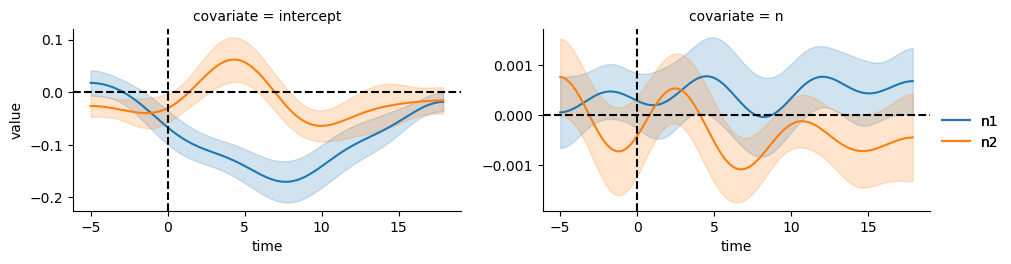

In [74]:
grf = nideconv.GroupResponseFitter(ts, onsets=onsets, input_sample_rate=1./2.3, confounds=confounds, concatenate_runs=False)
grf.add_event('n1', interval=[-5.0, 20], basis_set='dct', n_regressors=8, covariates='n')
grf.add_event('n2', interval=[-5.0, 20], basis_set='dct', n_regressors=8, covariates='n')
grf.fit()
grf.plot_groupwise_timecourses()

/Users/gdehol/git/nideconv/nideconv/regressors.py:338: UserWarning: Number of FIR regressors has automatically been set to 10 per covariate
  warnings.warn('Number of FIR regressors has automatically been set to %d '
/Users/gdehol/git/nideconv/nideconv/regressors.py:338: UserWarning: Number of FIR regressors has automatically been set to 10 per covariate
  warnings.warn('Number of FIR regressors has automatically been set to %d '
/Users/gdehol/git/nideconv/nideconv/regressors.py:338: UserWarning: Number of FIR regressors has automatically been set to 10 per covariate
  warnings.warn('Number of FIR regressors has automatically been set to %d '
/Users/gdehol/git/nideconv/nideconv/regressors.py:338: UserWarning: Number of FIR regressors has automatically been set to 10 per covariate
  warnings.warn('Number of FIR regressors has automatically been set to %d '
/Users/gdehol/git/nideconv/nideconv/regressors.py:338: UserWarning: Number of FIR regressors has automatically been set to 10 per co

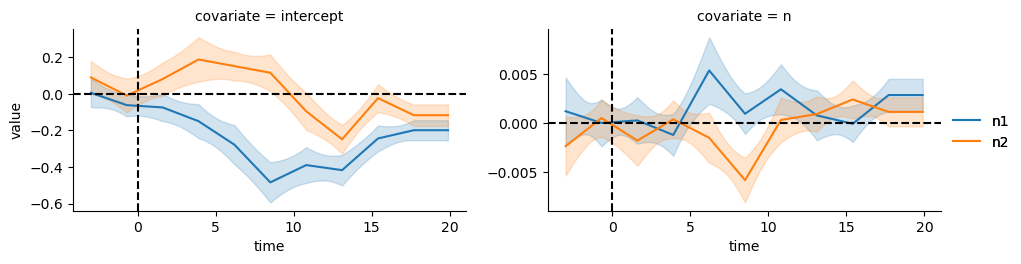

In [66]:
grf = nideconv.GroupResponseFitter(ts, onsets=onsets, input_sample_rate=1./2.3, confounds=confounds, concatenate_runs=False)
grf.add_event('n1', interval=[-3.0, 20], basis_set='fir2', covariates='n')
grf.add_event('n2', interval=[-3.0, 20], basis_set='fir2', covariates='n')
grf.fit()
grf.plot_groupwise_timecourses()